In [105]:
from pprint import PrettyPrinter
pp = PrettyPrinter(compact=True, indent=4, depth=3)
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import pandas as pd
import torch
import numpy as np
from tdigest import TDigest

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(helpers)
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

In [106]:
fst, snd = map(itemgetter, range(2))

In [107]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

path_to_experiments = Path('new_experiments/')
# path_to_experiments = Path('experiments/')

In [109]:
reload(helpers)
# dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
# dataset = 'fitzpatrick'

experiment_names = ['tct', 'fedavg', 'fedprox', 'central', 'tct_iid', 'fedavg_iid']
if dataset == 'fitzpatrick':
    # model = 'resnet18'
    # model = 'efficientnet-b0'
    model = 'efficientnet-b1'
    # model = 'efficientnet-b2'
    # model = 'efficientnet-b3'
    # partition = 'skin_type_partition'
    # partition = 'three_label_partition'
    partition = 'nine_label_partition'
    _val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'val_df.csv')
    _test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'test_df.csv')
    df = pd.concat([_val_df, _test_df]).reset_index()
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}_pretrained_{partition}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
        # 'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        # 'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    }
    num_classes = 114
    clients_class_map = None
else:
    clients_class_map = helpers.get_client_map(dataset)
    num_classes = sum(map(len, clients_class_map.values()))
    # model = 'cnn'
    model = 'small_resnet14'
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
    }
    partition = None
    
experiments = dict(filter(snd, experiments.items()))

In [110]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

In [111]:
reload(helpers)
trial_val_acc = defaultdict(list)
trial_test_acc = defaultdict(list) 
for trial in range(100):
    trial = helpers.get_new_trial(experiments)
    
    for k, v in trial['experiments'].items():
        trial_val_acc[k].append(accuracy(v['val_scores'], v['val_targets']))
        trial_test_acc[k].append(accuracy(v['test_scores'], v['test_targets']))

for k, v in trial_test_acc.items():
    print(f"\n{k.upper().center(20, '=')}")
    print('val\t', f'{np.mean(trial_val_acc[k]):.2f}')
    print('test\t', f'{np.mean(v):.2f}')
                                          


======CENTRAL=======
val	 0.61
test	 0.61

========TCT=========
val	 0.58
test	 0.58

=======FEDAVG=======
val	 0.33
test	 0.32

======FEDPROX=======
val	 0.31
test	 0.31

======TCT_IID=======
val	 0.62
test	 0.62

=====FEDAVG_IID=====
val	 0.60
test	 0.60


In [152]:
reload(cp)
reload(helpers)
reload(ts)
num_trials = 10

tct_trials = {}
fedavg_trials = {}
fedprox_trials = {}
central_trials = {}
naive_central_trials = {}
for i in range(num_trials):
    
    # randomly split into calibration and evaluation sets
    trial = helpers.get_new_trial(experiments, fitzpatrick_df=df if dataset == 'fitzpatrick' else None)
    trial_experiments = trial['experiments']
    val_df = trial['val_df']
    test_df = trial['test_df']

    # apply aggregate temperature scaling
    ts.client_temp_scale(
        trial_experiments, clients_class_map, 
        val_df=val_df, test_df=test_df,
        use_three_partition_label=True if partition == 'three_partition_label' else False,
    )
    
    # partition validation data into clients
    if dataset == 'fitzpatrick':
        _partition = 'three_partition_label' if partition == 'three_partition_label' else 'aggregated_fitzpatrick_scale'
        client_index_map = {
            str(part): (val_df[_partition] == part).values for part in sorted(val_df[_partition].unique())
        }
    else:
        client_index_map = {
            k: sum(trial_experiments['tct']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()
        }

    # conformal parameters
    # alphas = np.arange(0.05, 1, 0.05)
    alphas = np.arange(0.10, 1, 0.10)
    alphas = list(map(lambda x: np.round(x, 2), alphas))
    allow_empty_sets = False # set to True for upper marginal bound
    # allow_empty_sets = True
    method = 'lac' # score function: naive, lac, aps, raps
    # method = 'aps' 
    # method = 'raps' 

    f = itemgetter('temp_val_scores', 'val_targets', 'temp_test_scores', 'test_targets')
    # f = itemgetter('val_scores', 'val_targets', 'test_scores', 'test_targets')
    
    tct_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['tct']), method=method, 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=True, client_index_map=client_index_map,
    )
    tct_trials[i] = tct_metrics
    
    fedavg_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['fedavg']), method=method, 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=True, client_index_map=client_index_map,
    )
    fedavg_trials[i] = fedavg_metrics
    
    fedprox_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['fedprox']), method=method, 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=True, client_index_map=client_index_map,
    )
    fedprox_trials[i] = fedprox_metrics

    central_metrics = cp.get_coverage_size_over_alphas(
        *f(trial_experiments['central']), method=method, 
        allow_empty_sets=allow_empty_sets, alphas=alphas, 
        decentral=False,
    )
    central_trials[i] = central_metrics
    
    # naive_central_metrics = cp.get_coverage_size_over_alphas(
    #     *f(trial_experiments['central']), method='naive_lac', 
    #     allow_empty_sets=allow_empty_sets, alphas=alphas, 
    #     decentral=False,
    # )
    # naive_central_trials[i] = naive_central_metrics
    
    print(f'finished trial={i}')
    

finished trial=0
finished trial=1
finished trial=2
finished trial=3
finished trial=4
finished trial=5
finished trial=6
finished trial=7
finished trial=8
finished trial=9


In [153]:
reload(helpers)
tct_results = helpers.combine_trials(tct_trials)
fedavg_results = helpers.combine_trials(fedavg_trials)
fedprox_results = helpers.combine_trials(fedprox_trials)
central_results = helpers.combine_trials(central_trials)
# naive_central_results = helpers.combine_trials(naive_central_trials)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


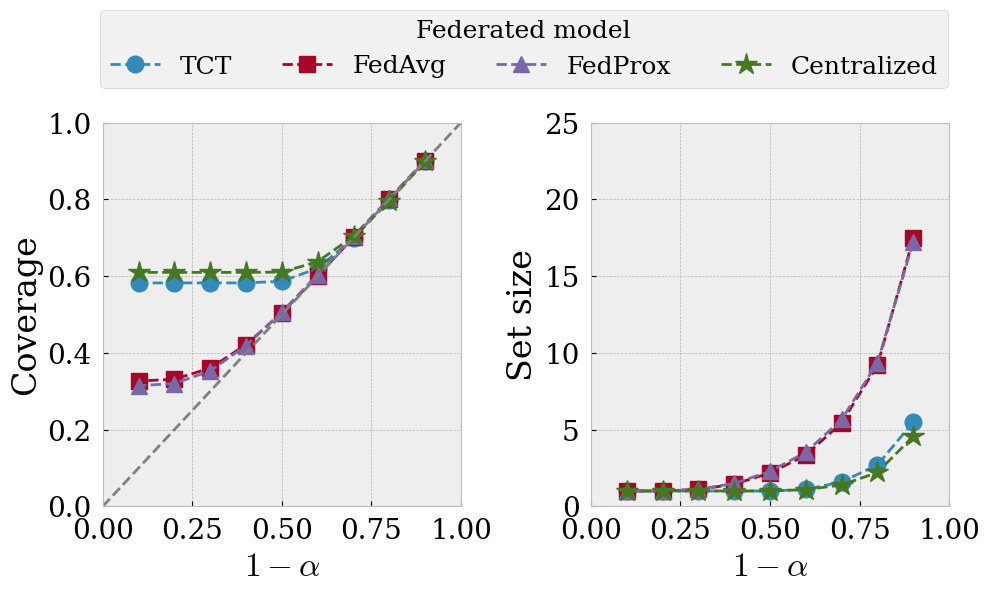

In [154]:
alphas = np.arange(0.10, 1, 0.10)
alphas = list(map(lambda x: np.round(x, 2), alphas))

# plotting settings
fontsize=24
style = '--'
markersize=12

exp_1 = central_results['mean']
exp_2 = tct_results['mean']
exp_3 = fedavg_results['mean']
exp_4 = fedprox_results['mean']
exp_1_label = 'Centralized'
exp_2_label = 'TCT'
exp_3_label = 'FedAvg'
exp_4_label = 'FedProx'


fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    
if exp_2 is not None:
    ax[0].plot(*zip(*exp_2['coverage'].items()), style, marker='o', label=exp_2_label, markersize=markersize, c='C0')
    ax[1].plot(*zip(*exp_2['size'].items()), style, marker='o',  markersize=markersize, c='C0')
    
if exp_3 is not None:
    ax[0].plot(*zip(*exp_3['coverage'].items()), style, marker='s', label=exp_3_label, markersize=markersize, c='C1')
    ax[1].plot(*zip(*exp_3['size'].items()), style, marker='s',  markersize=markersize, c='C1')
    
if exp_4 is not None:
    ax[0].plot(*zip(*exp_4['coverage'].items()), style, marker='^', label=exp_4_label, markersize=markersize, c='C2')
    ax[1].plot(*zip(*exp_4['size'].items()), style, marker='^',  markersize=markersize, c='C2')
    
if exp_1 is not None:
    ax[0].plot(*zip(*exp_1['coverage'].items()), style, marker='*', label=exp_1_label, markersize=markersize+4, c='C3')
    ax[1].plot(*zip(*exp_1['size'].items()), style, marker='*',  markersize=markersize+4, c='C3')


ax[0].plot([0, 1], [0, 1], '--', color='gray')

# ax[0].set_xlim(0.5, 1)
# ax[0].set_ylim(0.2, 1)
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)
# ax[0].set_ylim(0.20, 0.95)
# ax[0].set_ylim(0.25, 0.95)
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 25)
# ax[1].set_ylim(0, 9)
# ax[1].set_ylim(0, 35)
# ax[1].set_ylim(0, 40)
ax[0].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[1].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)
ax[1].set_ylabel('Set size', fontsize=fontsize)
# ax[0].set_xticks([0.4, 0.6, 0.7, 0.8, 0.9])
# ax[0].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
# ax[1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# ax[0].set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# ax[0].set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# ax[1].set_yticks([1, 2, 3, 4, 5, 6])
# ax[1].set_yticks([1, 5, 10, 15])
# ax[1].set_yticks([1, 2, 3, 4, 5])
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax[0].legend(fancybox=False, fontsize=fontsize-8, loc='lower center', framealpha=1.0)
# ax[1].legend(fancybox=False, fontsize=fontsize-8, loc='upper center', framealpha=1.0)
fig.legend(ncol=4, fontsize=fontsize - 6, 
          title='Federated model', title_fontsize=fontsize - 6, 
          bbox_to_anchor=(0.065, 0, 0.90, 1.20), fancybox = True, #shadow = True,
           # mode="expand",
 )

plt.tight_layout()
plt.savefig(fig_dir / f'experiment-1-{dataset}-{method}-temp.eps', bbox_inches='tight')
# plt.savefig(fig_dir / f'naive-{dataset}.eps', bbox_inches='tight')
plt.show()

In [116]:
alphas = [0.9, 0.8, 0.7]
# alphas = [0.1, 0.2, 0.3]
allow_empty_sets = False
# allow_empty_sets = True
method = 'lac'
precision=3

print('\n\n', 'Fedavg'.center(40, '='))
for k, v in fedavg_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))

print('\n\n', 'Fedprox'.center(40, '='))
for k, v in fedprox_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))
                
print('TCT'.center(40, '='))
for k, v in tct_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))


print('Central'.center(40, '='))
for k, v in central_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))



 =================Fedavg=================

 =============mean=============
========size========
0.9 	 23.4
0.8 	 13.2
0.7 	 8.23
======coverage======
0.9 	 0.9
0.8 	 0.8
0.7 	 0.7

 =============std==============
========size========
0.9 	 0.33
0.8 	 0.34
0.7 	 0.27
======coverage======
0.9 	 0.0
0.8 	 0.01
0.7 	 0.01


 ================Fedprox=================

 =============mean=============
========size========
0.9 	 23.07
0.8 	 13.14
0.7 	 8.19
======coverage======
0.9 	 0.9
0.8 	 0.8
0.7 	 0.7

 =============std==============
========size========
0.9 	 0.36
0.8 	 0.21
0.7 	 0.23
======coverage======
0.9 	 0.0
0.8 	 0.0
0.7 	 0.01
==================TCT===================

 =============mean=============
========size========
0.9 	 10.11
0.8 	 5.22
0.7 	 3.14
======coverage======
0.9 	 0.9
0.8 	 0.81
0.7 	 0.74

 =============std==============
========size========
0.9 	 0.3
0.8 	 0.15
0.7 	 0.1
======coverage======
0.9 	 0.01
0.8 	 0.01
0.7 	 0.01
================Central===========

In [117]:
print('\n\n', 'Fedavg'.center(40, '='))
for k, v in fedavg_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', ): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', f'{b/central_results[k][met][a]:.0%}')

print('\n\n', 'Fedprox'.center(40, '='))
for k, v in fedprox_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', ): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                # print(a, '\t', round(b, 2))
                print(a, '\t', f'{b/central_results[k][met][a]:.0%}')
                
print('TCT'.center(40, '='))
for k, v in tct_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', ): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                # print(a, '\t', round(b, 2))
                print(a, '\t', f'{b/central_results[k][met][a]:.0%}')



 =================Fedavg=================

 =============mean=============
========size========
0.9 	 241%
0.8 	 258%
0.7 	 253%

 =============std==============
========size========
0.9 	 181%
0.8 	 302%
0.7 	 338%


 ================Fedprox=================

 =============mean=============
========size========
0.9 	 237%
0.8 	 257%
0.7 	 252%

 =============std==============
========size========
0.9 	 197%
0.8 	 186%
0.7 	 285%
==================TCT===================

 =============mean=============
========size========
0.9 	 104%
0.8 	 102%
0.7 	 97%

 =============std==============
========size========
0.9 	 163%
0.8 	 129%
0.7 	 126%
